<a href="https://colab.research.google.com/github/LuzhiHan/lol/blob/master/ESA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 一、概述：多特征融合的中文隐式情感分析实验
  实验共分为六组，15个实验模型：



1.   第一组实验，共4个。评估预训练语言模型在隐式情感数据上的处理能力（ernie-gram,ernie-tiny,bert-zh-12-768-12，chinese-robert-wwm-ext，作为基准模型）

2.   第二组实验，共2个。分别评估RNN、CNN对隐式情感数据的处理能力，对照组为基准模型。

3.   第三组实验，共3个。分别测试RNN+上下文、CNN+上下文的处理效果，RNN+CNN+上下文的处理效果，对照组为第二组实验。
4.   第四组实验，共2。共分别测试RNN+attention+CNN+上下文，RNN+attention+CNN+attention+上下文效果，对照组为不加attention实验
5.   第五组实验，共2个。测试多路卷积网络对特征融合的效果，分别测试多特征+CNN,和多特征+全连接的方式，组内对照
6.   第六组实验，共2个。测试bert参数可训练模型与本模型的对比。

##1.1安装tensoflow2.8

In [ ]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install tensorflow_addons
!pip install matplotlib
!pip install pydot
!pip install pandas
!pip install matplotlib

     |████████████████████████████████| 462 kB 8.2 MB/s 
     |████████████████████████████████| 4.9 MB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 7.9 MB/s 


##1.2加载谷歌硬盘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 二、第一组实验--评估预训练语言模型
评估ernie,bet,robert,robert-wwm对隐式情感分析数据集的处理能力


## 2.1  ERNIE-Gram微调_0.8180

In [ ]:
!pip install paddlepaddle-gpu
!pip install paddlenlp
!pip install paddlehub

###2.1.1数据处理

In [ ]:
'''
从原始xml文件生成ERNIE-Gram所需的实验数据格式
'''
import re
import pandas as pd


def read_xml(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        xml_data = f.read()
    # 读取目标句和标签
    labeled_data = re.findall('<Sentence ID="\d+" label="(\d)">(.*?)</Sentence>', xml_data)
    text = []
    labels = []
    for tempdata in labeled_data:
        if (data_clean(tempdata[1]) != ''):
            text.append(data_clean(tempdata[1]))
            labels.append(int(tempdata[0]))

    content = []
    # 读取上下文句,一个上下文句包含多个目标句
    for index in re.findall('<Doc ID="\d+">(.*?)</Doc>', xml_data.replace('\n', '')):
        temp_str = ''
        count = 0
        for num, temp_data in re.findall(r'<Sentence ID="\d+"[ label="]*(\d)*["]*>(.*?)</Sentence>', index):
            # 提取出所有句子
            if (num != '' and data_clean(temp_data) == ''):
                count = count + 1
            temp_data = data_clean(temp_data)
            temp_str = temp_str + temp_data + '\t'
        times = str(index).count('label="1"') + str(index).count('label="2"') + str(index).count('label="0"') - count
        # 为每个目标句，分配一个上下文句
        for i in range(0, times):
            content.append(temp_str)
    print(len(content))
    return text, labels, content


def data_clean(text_for_clean):
   

    res_text = re.sub(r"(\\\\)?(回复)?(/)?\s*@\S*?\s*:", "@ ", text_for_clean)
    res_text1 = re.sub(r"@\S*", "@", res_text)
    res_text2 = re.sub(r"http://+[\w.\\\\]*", '', res_text1)
    res_text3 = re.sub(r"http:\\+[\w.\\\\]*", '', res_text2)
    res_text4 = re.sub(r"[\s/\\\\]", '', res_text3)
    return res_text4


def get_data(filename):
   
    temp_text, temp_labels, temp_content = read_xml(filename)
    # temp_text = [data_clean(each) for each in temp_text]
    # temp_content = [data_clean(each) for each in temp_content]
    return temp_text, temp_labels, temp_content


def save_data(datadir, save_path):
  
    temp_text, temp_labels, temp_content = get_data(datadir)
    data_final = pd.concat([pd.DataFrame(temp_text), pd.DataFrame(temp_labels)], axis=1)
    data_final.to_csv(save_path,  mode="w", header=['text', 'label'], index=False,index_label='index',sep='\t')
    return 0


def save_dev_test(datadir, save_path1, save_path2):
    
    temp_text, temp_labels, temp_content = get_data(datadir)
    num = len(temp_text) // 2
    dev_data = temp_text[0:num]
    dev_label = temp_labels[0:num]
    test_data = temp_text[num + 1:]
    test_label = temp_labels[num + 1:]
    dev_final = pd.concat([pd.DataFrame(dev_data), pd.DataFrame(dev_label)], axis=1)
    test_final = pd.concat([pd.DataFrame(test_data), pd.DataFrame(test_label)], axis=1)
    dev_final.to_csv(save_path1,  header=['text', 'label'], index=False, index_label='index', mode="w",sep='\t')
    test_final.to_csv(save_path2, header=['text', 'label'], index=False, index_label='index',mode="w",sep='\t')
    return 0


if __name__ == '__main__':
    save_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Train.xml', '/content/drive/MyDrive/ESA/cleaned_data/train.csv')

    save_dev_test('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Dev.xml', '/content/drive/MyDrive/ESA/cleaned_data/dev.csv',
                  '/content/drive/MyDrive/ESA/cleaned_data/test.csv')


###2.1.2ERNIE-Gram微调

In [ ]:
'''
ERNIE-Gram微调处理隐式情感分析任务：
eval loss: 0.47137, accu: 0.81797
'''
import paddle
import paddle.nn.functional as F
from functools import partial
from paddlenlp.data import Stack, Tuple, Pad
import numpy as np
from paddlenlp.datasets import load_dataset
from paddlenlp.transformers import  ErnieGramTokenizer,  ErnieGramForSequenceClassification
from paddlenlp.transformers import LinearDecayWithWarmup
from paddlenlp.data import Stack, Tuple, Pad
import paddle.nn as nn
from paddlenlp.transformers import ErnieGramTokenizer, ErnieGramForSequenceClassification

def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=128,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # Seperates data into some batches.
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        # The last batch whose size is less than the config batch_size setting.
        batches.append(one_batch)

    results = []
    model.eval()
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results


@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))
    model.train()
    metric.reset()


def convert_example(example, tokenizer, max_seq_length=128, is_test=False):
    encoded_inputs = tokenizer(text=example["text"], max_seq_len=max_seq_length)
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids


def create_dataloader(dataset,
                      mode='train',
                      batch_size=32,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)

    return paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        collate_fn=batchify_fn,
        return_list=True)


class mymodel(ErnieGramForSequenceClassification):

    def __init__(self, ernie_gram, num_classes=3, dropout=None):
        super(mymodel, self).__init__()
        self.num_classes = num_classes
        self.ernie_gram = ernie_gram  # allow ernie gram to be config
        self.dropout = nn.Dropout(dropout if dropout is not None else
                                  self.ernie_gram.config["hidden_dropout_prob"])
        self.classifier = nn.Linear(self.ernie_gram.config["hidden_size"],
                                    num_classes)
        self.apply(self.init_weights)

    def forward(self,
                input_ids,
                token_type_ids=None,
                position_ids=None,
                attention_mask=None):
        _, pooled_output = self.ernie_gram(
            input_ids,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            attention_mask=attention_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

def read(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            words, labels = line.strip('\n').split('\t')
            yield {'text': words, 'label': labels}


train_ds = load_dataset(read, data_path='/content/drive/MyDrive/ESA/cleaned_data/train.csv', lazy=False)
dev_ds = load_dataset(read, data_path='/content/drive/MyDrive/ESA/cleaned_data/dev.csv', lazy=False)
test_ds = load_dataset(read, data_path='/content/drive/MyDrive/ESA/cleaned_data/test.csv', lazy=False)
print(len(train_ds))

tokenizer = ErnieGramTokenizer.from_pretrained('ernie-gram-zh')
model = ErnieGramForSequenceClassification.from_pretrained('ernie-gram-zh', num_classes=3)
# 模型运行批处理大小
batch_size = 64
max_seq_length = 32

trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # segment
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]
train_data_loader = create_dataloader(
    dataset=train_ds.map(trans_func),
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
dev_data_loader = create_dataloader(
    dataset=dev_ds.map(trans_func),
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
test_data_loader = create_dataloader(
    dataset=test_ds.map(trans_func),
    mode='test',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
)
# 训练过程中的最大学习率
learning_rate = 5e-5
# 训练轮次
epochs = 3
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()
metric = paddle.metric.Accuracy()
global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 10 == 0:
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    evaluate(model, criterion, metric, dev_data_loader)
evaluate(model, criterion, metric, test_data_loader)
model.save_pretrained('/content/drive/MyDrive/ESA/checkpoint/ERNIE-Gram')
tokenizer.save_pretrained('/content/drive/MyDrive/ESA/checkpoint/ERNIE-Gram')


## 2.2 ERNIE-Tiny微调_0.8102

In [ ]:
!pip install jieba
!pip install paddlepaddle-gpu
!pip install paddlenlp
!pip install paddlehub
!pip install sentencepiece

###2.2.1数据处理

In [ ]:
'''
从原始xml文件生成ERNIE-Tiny所需的数据
'''
import re
import pandas as pd
import jieba

def read_xml(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        xml_data = f.read()
    # 读取目标句和标签
    labeled_data = re.findall('<Sentence ID="\d+" label="(\d)">(.*?)</Sentence>', xml_data)
    text = []
    labels = []
    for tempdata in labeled_data:
        if (data_clean(tempdata[1]) != ''):
            text.append(data_clean(tempdata[1]))
            labels.append(int(tempdata[0]))

    content = []
    # 读取上下文句,一个上下文句包含多个目标句
    for index in re.findall('<Doc ID="\d+">(.*?)</Doc>', xml_data.replace('\n', '')):
        temp_str = ''
        count = 0
        for num, temp_data in re.findall(r'<Sentence ID="\d+"[ label="]*(\d)*["]*>(.*?)</Sentence>', index):
            # 提取出所有句子
            if (num != '' and data_clean(temp_data) == ''):
                count = count + 1
            temp_data = data_clean(temp_data)
            temp_str = temp_str + temp_data + '\t'
        times = str(index).count('label="1"') + str(index).count('label="2"') + str(index).count('label="0"') - count
        # 为每个目标句，分配一个上下文句
        for i in range(0, times):
            content.append(temp_str)
    
    return text, labels, content


def data_clean(text_for_clean):
    res_text = re.sub(r"(\\\\)?(回复)?(/)?\s*@\S*?\s*:", "@ ", text_for_clean)
    res_text1 = re.sub(r"@\S*", "@", res_text)
    res_text2 = re.sub(r"http://+[\w.\\\\]*", '', res_text1)
    res_text3 = re.sub(r"http:\\+[\w.\\\\]*", '', res_text2)
    res_text4 = re.sub(r"[/\\\\]", '', res_text3)
    re_data=jieba.cut(res_text4,cut_all=False)
    f_data=" ".join(re_data)
    return f_data


def get_data(filename):

    temp_text, temp_labels, temp_content = read_xml(filename)
    # temp_text = [data_clean(each) for each in temp_text]
    # temp_content = [data_clean(each) for each in temp_content]
    return temp_text, temp_labels, temp_content


def save_data(datadir, save_path):

    temp_text, temp_labels, temp_content = get_data(datadir)
    data_final = pd.concat([pd.DataFrame(temp_labels), pd.DataFrame(temp_text)], axis=1)
    data_final.to_csv(save_path, sep='\t', mode="w", header=['text', 'label'], index=False)
    return 0


def save_dev_test(datadir, save_path1, save_path2):

    temp_text, temp_labels, temp_content = get_data(datadir)
    num = len(temp_text) // 2
    dev_data = temp_text[0:num]
    dev_label = temp_labels[0:num]
    test_data = temp_text[num + 1:]
    test_label = temp_labels[num + 1:]
    dev_final = pd.concat([pd.DataFrame(dev_label), pd.DataFrame(dev_data)], axis=1)
    test_final = pd.concat([pd.DataFrame(test_label), pd.DataFrame(test_data)], axis=1)
    dev_final.to_csv(save_path1, sep='\t', header=['text', 'label'], index=False, mode="w")
    test_final.to_csv(save_path2, sep='\t', header=['text', 'label'], index=False, mode="w")
    return 0


if __name__ == '__main__':
    save_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Train.xml', '../data_set/text_label_train.csv')

    save_dev_test('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Dev.xml', '../data_set/text_label_dev.csv',
                  '../data_set/text_label_test.csv')


###2.2.2ERNIE-Tiny微调

In [ ]:
'''
ERNIE-Tiny微调处理隐式情感分析任务：
best_acc=0.8102
'''
import pandas as pd
import paddle
import paddlehub as hub
import ast
import argparse
from paddlehub.datasets.base_nlp_dataset import TextClassificationDataset

class MyDataset(TextClassificationDataset):
    # 数据集存放目录
    base_path = '/content/drive/MyDrive/ESA/cleaned_data'
    # 数据集的标签列表，多分类标签格式为['0', '1', '2', '3',...]
    label_list = ['0', '1', '2']

    def __init__(self, tokenizer, max_seq_len: int = 64, mode: str = 'train'):
        if mode == 'train':
            data_file = 'text_label_train.tsv'
        elif mode == 'test':
            data_file = 'text_label_test.tsv'
        else:
            data_file = 'text_label_dev.tsv'
        super().__init__(
            base_path=self.base_path,
            tokenizer=tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            data_file=data_file,
            label_list=self.label_list,
            is_file_with_header=True)


if __name__ == '__main__':

    # 选择模型、任务和类别数
    model = hub.Module(name='ernie_tiny', task='seq-cls', num_classes=len(MyDataset.label_list))

    train_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='train')
    dev_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='dev')
    test_dataset = MyDataset(tokenizer=model.get_tokenizer(), max_seq_len=64, mode='test')

    optimizer = paddle.optimizer.Adam(learning_rate=5e-5, parameters=model.parameters())
    trainer = hub.Trainer(model, optimizer, checkpoint_dir='/content/drive/MyDrive/ESA/checkpoint/ERNIE-Tiny', use_gpu=True)
    trainer.train(train_dataset, epochs=2, batch_size=64, eval_dataset=dev_dataset,save_interval=1)
    # 在测试集上评估当前训练模型
    trainer.evaluate(test_dataset, batch_size=64)
    


##2.3 chinese-roberta-wwm-ext微调_0.8196

In [ ]:
!pip install transformers
!pip install datasets

###2.3.1数据处理

In [ ]:
import re
import pandas as pd


def read_xml(filename):
    with open(filename, 'r',encoding='utf-8') as f:
        xml_data = f.read()
    # 读取目标句和标签
    labeled_data = re.findall('<Sentence ID="\d+" label="(\d)">(.*?)</Sentence>', xml_data)
    text = []
    labels = []
    for tempdata in labeled_data:
        if (data_clean(tempdata[1]) != ''):
            text.append(data_clean(tempdata[1]))
            labels.append(int(tempdata[0]))

    content = []
    # 读取上下文句,一个上下文句包含多个目标句
    for index in re.findall('<Doc ID="\d+">(.*?)</Doc>', xml_data.replace('\n', '')):
        temp_str = ''
        count = 0
        for num, temp_data in re.findall(r'<Sentence ID="\d+"[ label="]*(\d)*["]*>(.*?)</Sentence>', index):
            # 提取出所有句子
            if (num != '' and data_clean(temp_data) == ''):
                count = count + 1
            temp_data = data_clean(temp_data)
            temp_str = temp_str + temp_data + '\t'
        times = str(index).count('label="1"') + str(index).count('label="2"') + str(index).count('label="0"')-count
        # 为每个目标句，分配一个上下文句
        for i in range(0, times):
            content.append(temp_str)
    print(len(content))
    return text, labels, content


def data_clean(text_for_clean):

    res_text = re.sub(r"(\\\\)?(回复)?(/)?\s*@\S*?\s*:", "@ ", text_for_clean)
    res_text1 = re.sub(r"@\S*", "@", res_text)
    res_text2 = re.sub(r"http://+[\w.\\\\]*", '', res_text1)
    res_text3 = re.sub(r"http:\\+[\w.\\\\]*", '', res_text2)
    res_text4=re.sub(r"[\s/\\\\]",'',res_text3)
    return res_text4


def get_data(filename):

    temp_text, temp_labels, temp_content = read_xml(filename)
    return temp_text, temp_labels, temp_content


def save_cleaned_data(temp_text, temp_labels, temp_content, filepath):
    data_final = pd.concat([pd.DataFrame(temp_text), pd.DataFrame(temp_labels), pd.DataFrame(temp_content)], axis=1)
    data_final.to_csv(filepath, encoding='utf_8_sig', header=['text', 'label', 'content'], index=False)
    return 0
if __name__ == '__main__':
    text, labels, content = get_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Train.xml')
    save_cleaned_data(text, labels, content, '/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv')
    text2, labels2, content2 = get_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Dev.xml')
    save_cleaned_data(text2, labels2, content2, '/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv')


###2.3.2微调处理隐式情感分析任务

In [ ]:
'''
loss: 0.4451 - accuracy: 0.8196
'''
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer
import tensorflow as tf
a=transformers.models.bert.tokenization_bert
tokenizer = BertTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
# 读取data.csv数据，并将第一列作为data,第二列作为label，数据总量14774作为训练集
print("读取data.csv")
raw_train_data = load_dataset('csv', data_files='/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv', split='train')
raw_test_data_set = load_dataset('csv', data_files='/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv', split='train')
data_for_dev_test = raw_test_data_set.train_test_split(test_size=0.5, train_size=0.5)
raw_dev_data = data_for_dev_test["train"]
raw_test_data = data_for_dev_test["test"]
max_length = 64


def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=max_length, padding="max_length", truncation=True,)


def get_encode_data(raw_data):
    tokenized_train_data = raw_data.map(tokenize_function, batched=True)
    tf_train_dataset = tokenized_train_data.with_format("tensorflow")
    train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
    encode_train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(128)
    return encode_train_tf_dataset


encode_train_dataset = get_encode_data(raw_train_data)
encode_dev_dataset = get_encode_data(raw_dev_data)
encode_test_dataset = get_encode_data(raw_test_data)

from transformers import TFBertForSequenceClassification

lr = 5e-5
epoch = 2
print("加载模型")
model = TFBertForSequenceClassification.from_pretrained("hfl/chinese-roberta-wwm-ext", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
print("模型训练")
model.fit(encode_train_dataset, epochs=epoch, validation_data=encode_dev_dataset)
print("模型评估")
model.evaluate(encode_test_dataset)
model.save("/content/drive/MyDrive/ESA/checkpoint/wwm")


##2.4 bert_base_chinese微调_0.8145

In [ ]:
!pip install transformers
!pip install datasets

###2.4.1 **数据处理**

In [ ]:
import re
import pandas as pd


def read_xml(filename):
    with open(filename, 'r',encoding='utf-8') as f:
        xml_data = f.read()
    # 读取目标句和标签
    labeled_data = re.findall('<Sentence ID="\d+" label="(\d)">(.*?)</Sentence>', xml_data)
    text = []
    labels = []
    for tempdata in labeled_data:
        if (data_clean(tempdata[1]) != ''):
            text.append(data_clean(tempdata[1]))
            labels.append(int(tempdata[0]))

    content = []
    # 读取上下文句,一个上下文句包含多个目标句
    for index in re.findall('<Doc ID="\d+">(.*?)</Doc>', xml_data.replace('\n', '')):
        temp_str = ''
        count = 0
        for num, temp_data in re.findall(r'<Sentence ID="\d+"[ label="]*(\d)*["]*>(.*?)</Sentence>', index):
            # 提取出所有句子
            if (num != '' and data_clean(temp_data) == ''):
                count = count + 1
            temp_data = data_clean(temp_data)
            temp_str = temp_str + temp_data + '\t'
        times = str(index).count('label="1"') + str(index).count('label="2"') + str(index).count('label="0"')-count
        # 为每个目标句，分配一个上下文句
        for i in range(0, times):
            content.append(temp_str)
    print(len(content))
    return text, labels, content


def data_clean(text_for_clean):

    res_text = re.sub(r"(\\\\)?(回复)?(/)?\s*@\S*?\s*:", "@ ", text_for_clean)
    res_text1 = re.sub(r"@\S*", "@", res_text)
    res_text2 = re.sub(r"http://+[\w.\\\\]*", '', res_text1)
    res_text3 = re.sub(r"http:\\+[\w.\\\\]*", '', res_text2)
    res_text4=re.sub(r"[\s/\\\\]",'',res_text3)
    return res_text4


def get_data(filename):

    temp_text, temp_labels, temp_content = read_xml(filename)
    return temp_text, temp_labels, temp_content


def save_cleaned_data(temp_text, temp_labels, temp_content, filepath):
    data_final = pd.concat([pd.DataFrame(temp_text), pd.DataFrame(temp_labels), pd.DataFrame(temp_content)], axis=1)
    data_final.to_csv(filepath, encoding='utf_8_sig', header=['text', 'label', 'content'], index=False)
    return 0
if __name__ == '__main__':
    text, labels, content = get_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Train.xml')
    save_cleaned_data(text, labels, content, '/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv')
    text2, labels2, content2 = get_data('/content/drive/MyDrive/ESA/raw_data/SMP2019_ECISA_Dev.xml')
    save_cleaned_data(text2, labels2, content2, '/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv')


###2.4.2微调处理隐式情感分析任务

In [ ]:
'''
bert-base-chinese处理隐式情感分析：
loss: 0.5009 - accuracy: 0.8145
'''

from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

print("读取data.csv")
raw_train_data = load_dataset('csv', data_files='/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv', split='train')
raw_test_data_set = load_dataset('csv', data_files='/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv', split='train')
data_for_dev_test = raw_test_data_set.train_test_split(test_size=0.5, train_size=0.5)
raw_dev_data = data_for_dev_test["train"]
raw_test_data = data_for_dev_test["test"]
max_length = 64


def tokenize_function(examples):
    return tokenizer(examples['text'], max_length=max_length, padding="max_length", truncation=True)


def get_encode_data(raw_data):
    tokenized_train_data = raw_data.map(tokenize_function, batched=True)
    tf_train_dataset = tokenized_train_data.with_format("tensorflow")
    train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
    encode_train_tf_dataset = train_tf_dataset.shuffle(len(train_tf_dataset)).batch(64)
    return encode_train_tf_dataset


encode_train_dataset = get_encode_data(raw_train_data)
encode_dev_dataset = get_encode_data(raw_dev_data)
encode_test_dataset = get_encode_data(raw_test_data)

from transformers import TFBertForSequenceClassification

lr = 5e-5
epoch = 2
print("加载模型")
model = TFBertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
print("模型训练")
model.fit(encode_train_dataset, epochs=epoch, validation_data=encode_dev_dataset)
print("模型评估")
model.evaluate(encode_test_dataset)
model.save("/content/drive/MyDrive/ESA/checkpoint/bert_base")
# model.evaluate(test_data_encode)




读取data.csv


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

加载模型


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型训练
Epoch 1/2
231/231 [==============================] - 210s 822ms/step - loss: 0.5705 - accuracy: 0.7671 - val_loss: 0.4165 - val_accuracy: 0.8327
Epoch 2/2
231/231 [==============================] - 186s 807ms/step - loss: 0.3586 - accuracy: 0.8664 - val_loss: 0.4544 - val_accuracy: 0.8215
模型评估
41/41 [==============================] - 11s 259ms/step - loss: 0.5009 - accuracy: 0.8145


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ESA/checkpoint/bert_base/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ESA/checkpoint/bert_base/assets


#三、第二组实验-分别测试bert_embeddings接CNN、GRU效果

##3.1bert_embeddings+GRU

###3.1.1 GRU_32*32_512-256_0.7700

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model (Functional)             {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_type_ids':                                                
                                (None, 32)}                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


462/462 [==============================] - 86s 154ms/step - loss: 0.6968 - sparse_categorical_accuracy: 0.7054 - val_loss: 0.5919 - val_sparse_categorical_accuracy: 0.7636
Epoch 2/10
462/462 [==============================] - 71s 154ms/step - loss: 0.5585 - sparse_categorical_accuracy: 0.7740 - val_loss: 0.5545 - val_sparse_categorical_accuracy: 0.7688
Epoch 3/10
462/462 [==============================] - 71s 153ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.5601 - val_sparse_categorical_accuracy: 0.7668
Epoch 4/10
462/462 [==============================] - 74s 161ms/step - loss: 0.4987 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.5324 - val_sparse_categorical_accuracy: 0.7748
Epoch 5/10
462/462 [==============================] - 73s 158ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.5397 - val_sparse_categorical_accuracy: 0.7708
Epoch 6/10
462/462 [==============================] - 72s 155ms/step - loss: 0.4683 - sparse_cat

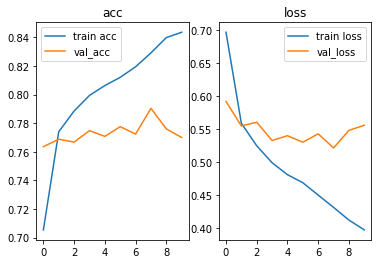

In [ ]:
'''
loss: 0.5009 - accuracy: 0.8145
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3=keras.layers.Flatten()(net3)
    net3=keras.layers.Dropout(0.2)(net3)
    net3=keras.layers.Dense(3,activation="softmax")(net3)
    return keras.Model(text_input,net3)


model = build_classifier_model()
plot_model(model,to_file="/content/drive/MyDrive/ESA/checkpoint/gru/model.png",show_shapes=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=32,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


###3.1.2 GRU_64*32_512-256_0.7836

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_2 (Functional)           {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_type_ids':                                                
                                (None, 32),                                                       
                                 'input_word_ids':                                                
                                (None, 32)}                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


231/231 [==============================] - 96s 371ms/step - loss: 0.7464 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.6059 - val_sparse_categorical_accuracy: 0.7568
Epoch 2/10
231/231 [==============================] - 85s 368ms/step - loss: 0.5792 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.5679 - val_sparse_categorical_accuracy: 0.7632
Epoch 3/10
231/231 [==============================] - 85s 367ms/step - loss: 0.5398 - sparse_categorical_accuracy: 0.7799 - val_loss: 0.5581 - val_sparse_categorical_accuracy: 0.7708
Epoch 4/10
231/231 [==============================] - 84s 363ms/step - loss: 0.5198 - sparse_categorical_accuracy: 0.7875 - val_loss: 0.5476 - val_sparse_categorical_accuracy: 0.7740
Epoch 5/10
231/231 [==============================] - 84s 362ms/step - loss: 0.4979 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.5331 - val_sparse_categorical_accuracy: 0.7812
Epoch 6/10
231/231 [==============================] - 83s 359ms/step - loss: 0.4818 - sparse_cat

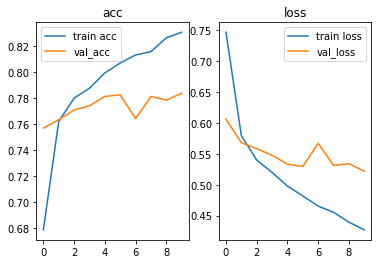

In [ ]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3=keras.layers.Flatten()(net3)
    net3=keras.layers.Dropout(0.2)(net3)
    net3=keras.layers.Dense(3,activation="softmax")(net3)
    return keras.Model(text_input,net3)


model = build_classifier_model()
plot_model(model,to_file="/content/drive/MyDrive/ESA/checkpoint/gru2/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru2/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


###3.1.3 GRU_64*32_768_0.7836

In [ ]:
'''
0.7836
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid")(net3)
    #net3 = keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3=keras.layers.Flatten()(net3)
    net3=keras.layers.Dropout(0.2)(net3)
    net3=keras.layers.Dense(3,activation="softmax")(net3)
    return keras.Model(text_input,net3)


model = build_classifier_model()
plot_model(model,to_file="/content/drive/MyDrive/ESA/checkpoint/gru3/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru3/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=0, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_2 (Functional)           {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_type_ids':                                                
                                (None, 32)}                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_2 (Functional)           {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_type_ids':                                                
                                (None, 32)}                                                 

KeyError: ignored

###3.1.4 GRU-64*32_768-768-0.7912

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model (Functional)             {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 32),                                                       
                                 'input_mask': (Non                                               
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32)}                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


231/231 [==============================] - 218s 844ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.5804 - val_sparse_categorical_accuracy: 0.7572
Epoch 2/10
231/231 [==============================] - 174s 752ms/step - loss: 0.5550 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.5426 - val_sparse_categorical_accuracy: 0.7732
Epoch 3/10
231/231 [==============================] - 173s 747ms/step - loss: 0.5223 - sparse_categorical_accuracy: 0.7874 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.7828
Epoch 4/10
231/231 [==============================] - 170s 736ms/step - loss: 0.4964 - sparse_categorical_accuracy: 0.8003 - val_loss: 0.5285 - val_sparse_categorical_accuracy: 0.7744
Epoch 5/10
231/231 [==============================] - 173s 748ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.7796
Epoch 6/10
231/231 [==============================] - 170s 734ms/step - loss: 0.4649 - spar

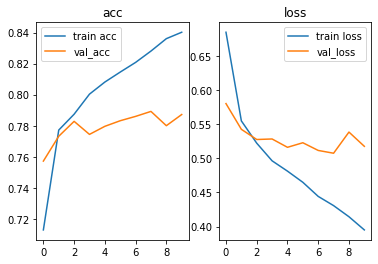

In [ ]:
'''
0.7912
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3=keras.layers.Flatten()(net3)
    net3=keras.layers.Dropout(0.2)(net3)
    net3=keras.layers.Dense(3,activation="softmax")(net3)
    return keras.Model(text_input,net3)


model = build_classifier_model()
plot_model(model,to_file="/content/drive/MyDrive/ESA/checkpoint/gru4/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru4/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()

##3.2 bert_embeddings+CNN

###3.2.1 TextCNN_64*32_1024-256-0.7860

In [ ]:
'''
0.7860
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1=keras.layers.Activation('relu')(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.3)(r1)
    net3=keras.layers.Dense(3,activation="softmax")(r1)
    return keras.Model(text_input,net3)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/cnn1"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/cnn1/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()

###3.2.2 TextCNN_64*32_1024-512-256_0.7956

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_10 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_type_ids':                                                
                                (None, 32)}                                                

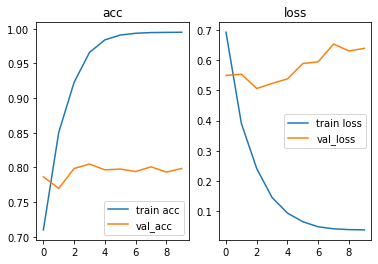

In [ ]:
'''
0.7956
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1=keras.layers.Activation('relu')(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(256, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    net3=keras.layers.Dense(3,activation="softmax")(r1)
    return keras.Model(text_input,net3)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/cnn2"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/cnn2/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()

###3.2.3 TextCNN_64*32_1024-bn-768-0.7744

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_12 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_type_ids':                                                
                                (None, 32),                                                       
                                 'input_word_ids':                                                
                                (None, 32)}                                                

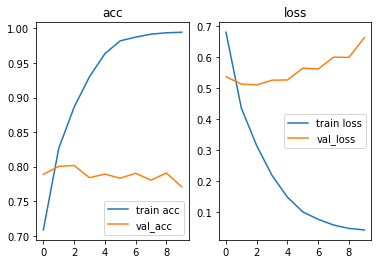

In [ ]:
'''
0.7744
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, padding="same", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1=keras.layers.Activation('relu')(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(256, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    net3=keras.layers.Dense(3,activation="softmax")(r1)
    return keras.Model(text_input,net3)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/cnn3"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/cnn3/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()

# 四、第三组实验，测试bert_embeddings+GRU/CNN+Attention

## 4.1 bert_embeddings+GRU+Attention

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3=keras.layers.Attention()([net3,net3])
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3=keras.layers.Flatten()(net3)
    net3=keras.layers.Dropout(0.2)(net3)
    net3=keras.layers.Dense(3,activation="softmax")(net3)
    return keras.Model(text_input,net3)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_att"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_att/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=x_test,y=y_test)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model (Functional)             {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_type_ids':                                                
                                (None, 32),                                                       
                                 'input_word_ids':                                                
                                (None, 32)}                                                 

##4.2 bert_embeddings+CNN+Attention

In [ ]:
'''
0.7956
'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1=keras.layers.Activation('relu')(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(r1)
    r1=keras.layers.Attention()([r1,r1])
    r1 = keras.layers.Conv1D(256, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    net3=keras.layers.Dense(3,activation="softmax")(r1)
    return keras.Model(text_input,net3)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/cnn_att"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/cnn_att/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
model_history = model.fit(x_train, y=y_train, epochs=10, batch_size=64,
                          validation_data=(x_dev, y_dev),
                          validation_freq=1,
                          callbacks=[model_callback],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
model.evaluate(x=x_test,y=y_test)
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_18 (Functional)          {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 32),                                                       
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_mask': (Non                                               
                                e, 32)}                                                    

#五、第四组实验-测试多特征组合效果-3组

##5.1 GRU+BiGRU-attention_ 0.8196

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text2 (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_6 (Functional)           {'input_word_ids':   0           ['text[0][0]',                   
                                (None, 128),                      'text2[0][0]']                  
                                 'input_mask': (Non                                               
                                e, 128),                                                    

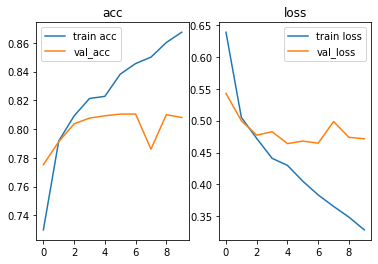

79/79 [==============================] - 35s 448ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.8196


[0.4700234830379486, 0.819599986076355]

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
x2_data=np.array(data["content"])
y_data = np.array(data["label"])

x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=128):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'])


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder_inputs2 = bert_preprocess_model(text_input2)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    outputs2 = encoder(encoder_inputs2)
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid")(net3)
    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid"))(net2)
    net=keras.layers.Concatenate(axis=-1)([net2,net3])
    net=keras.layers.Dropout(0.2)(net)
    net=keras.layers.Dense(3,activation="softmax")(net)
    return keras.Model([text_input,text_input2],net)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_bigru"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_bigru/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=4)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

##5.2 CNN-attention+BiGRU-attention_0.79040

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_43 (Functional)          {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 40),                                                       
                                 'input_word_ids':                                                
                                (None, 40),                                                       
                                 'input_mask': (Non                                               
                                e, 40)}                                                    

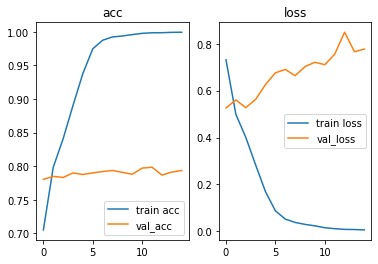

79/79 [==============================] - 30s 374ms/step - loss: 0.4939 - sparse_categorical_accuracy: 0.7904


[0.4939192235469818, 0.7904000282287598]

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
x2_data=np.array(data["content"])
y_data = np.array(data["label"])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=128):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=40)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

  


    encoder_inputs = bert_preprocess_model(text_input)
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    outputs2 = encoder(encoder_inputs2)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net3)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1=keras.layers.LayerNormalization()(r1)
    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid"))(net2)
    net2= keras.layers.LayerNormalization()(net2)
    net=keras.layers.Concatenate(axis=-1)([r1,net2])
    net=keras.layers.Dropout(0.3)(net)
    net=keras.layers.Dense(3,activation="softmax")(net)
    return keras.Model([text_input,text_input2],net)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/cnn_bigru"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/cnn_bigru/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=3)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

##5.3 GRU-attention+CNN-attention+BiGRU-attention_0.8020

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_2 (Functional)           {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 40),                                                       
                                 'input_type_ids':                                                
                                (None, 40),                                                       
                                 'input_mask': (Non                                               
                                e, 40)}                                                     

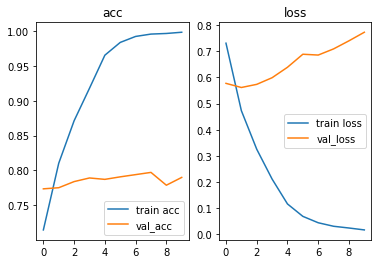

79/79 [==============================] - 30s 373ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8020


[0.4957854151725769, 0.8019999861717224]

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x2_data = np.array(data['content'])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=40)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

  


    encoder_inputs = bert_preprocess_model(text_input)
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    outputs2 = encoder(encoder_inputs2)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="valid", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1=keras.layers.Attention()([r1,r1])
    r1 = keras.layers.Flatten()(r1)
    r1=keras.layers.LayerNormalization()(r1)

    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3 = keras.layers.LayerNormalization()(net3)



    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid"))(net2)
    net2= keras.layers.LayerNormalization()(net2)
    net=keras.layers.Concatenate(axis=-1)([r1,net2,net3])
    net=keras.layers.Dropout(0.3)(net)
    net=keras.layers.Dense(3,activation="softmax")(net)
    return keras.Model([text_input,text_input2],net)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=2)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

##5.3.4CNN_GRU_BIGRU_0.8048

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_11 (Functional)          {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 40),                                                       
                                 'input_type_ids':                                                
                                (None, 40),                                                       
                                 'input_mask': (Non                                               
                                e, 40)}                                                    

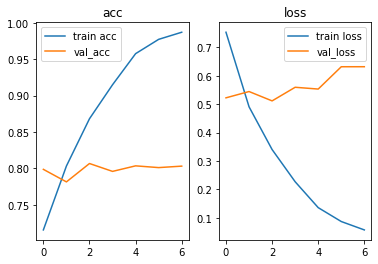

79/79 [==============================] - 30s 382ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.8048


[0.4923635721206665, 0.8047999739646912]

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x2_data = np.array(data['content'])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=40)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

  


    encoder_inputs = bert_preprocess_model(text_input)
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    outputs2 = encoder(encoder_inputs2)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="valid", strides=1)(net3)
    r1=keras.layers.BatchNormalization()(r1)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Conv1D(64, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1=keras.layers.Attention()([r1,r1])
    r1 = keras.layers.Flatten()(r1)
    r1=keras.layers.LayerNormalization()(r1)

    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3 = keras.layers.LayerNormalization()(net3)



    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid"))(net2)
    net2= keras.layers.LayerNormalization()(net2)
    net=keras.layers.Concatenate(axis=-1)([r1,net2,net3])
    net=keras.layers.Dropout(0.3)(net)
    net=keras.layers.Dense(3,activation="softmax")(net)
    return keras.Model([text_input,text_input2],net)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru2"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru2/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=4)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

In [ ]:
'''

'''
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
#os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x2_data = np.array(data['content'])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=32):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=64)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

  


    encoder_inputs = bert_preprocess_model(text_input)
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    outputs2 = encoder(encoder_inputs2)
    net3 = outputs['sequence_output']
    r1 = keras.layers.Conv1D(1024, 3, activation="relu", padding="valid", strides=1)(net3)
    r1 = keras.layers.Conv1D(512, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="valid", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = keras.layers.Dropout(0.2)(r1)
    r1 = keras.layers.Dense(512,activation="softmax")(r1)

    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid")(net3)
    net3 = keras.layers.Dense(512, activation="softmax")(net3)



    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(768, activation="tanh", recurrent_activation="sigmoid"))(net2)
    net2=keras.layers.Dropout(0.2)(net2)
    net2 = keras.layers.Dense(512, activation="softmax")(net2)
    net=keras.layers.Concatenate(axis=-1)([r1,net2,net3])
    net=keras.layers.Dropout(0.2)(net)
    net=keras.layers.Dense(3,activation="softmax")(net)
    return keras.Model([text_input,text_input2],net)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru3"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru3/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=4)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_31 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 64),                                                           
                                 'input_word_ids':                                                
                                (None, 64),                                                       
                                 'input_type_ids':                                                
                                (None, 64)}                                                

KeyboardInterrupt: ignored

#六、第五组实验-对比多路卷积神经网络和全连接层融合特征效果

##6.1 GRU-attention+CNN-attention+BiGRU-attention+MulCNN_0.8208

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_40 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                               

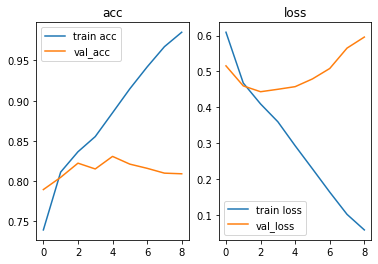

79/79 [==============================] - 37s 468ms/step - loss: 0.4542 - sparse_categorical_accuracy: 0.8208


[0.4542492628097534, 0.8208000063896179]

In [ ]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import typing

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
# os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')

# 读取数据
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x2_data = np.array(data['content'])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=50):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=128)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

    # preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False,
                             name='BERT_encoder')
    # 输入batch*seq 输出batch*seq*768
    outputs = encoder(encoder_inputs)
    # 输入batch*seq*768,输出batch*seq*512
    net = outputs['sequence_output']
    net = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Attention()([net, net])
    # 输入batch*seq*768,输出batch*seq*512
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.Attention()([net3, net3])

    # 输入batch*seq*768,输出batch*seq*512
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder2 = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=False, name='BERT_encoder2')
    outputs2 = encoder2(encoder_inputs2)
    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Attention()([net2, net2])
    # 输入3*batch*seq*512,输出batch*seq*1536
    net4 = keras.layers.Concatenate(axis=-1)([net, net2, net3])
    # 输入2*batch*seq*512,输出batch*seq*1024
    net5 = keras.layers.Concatenate(axis=-1)([net, net2])
    net6 = keras.layers.Concatenate(axis=-1)([net2, net3])
    net7 = keras.layers.Concatenate(axis=-1)([net, net3])
    # 输入batch*seq*1536输出batch*seq/2*64
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net)
    r1 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    r1 = keras.layers.Dense(128, activation='relu')(r1)

    r2 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net2)
    r2 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r2)
    r2 = keras.layers.MaxPooling1D(2)(r2)
    r2 = keras.layers.Flatten()(r2)
    r2 = tf.keras.layers.Dropout(0.2)(r2)
    r2 = keras.layers.Dense(128, activation='relu')(r2)

    r3 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net3)
    r3 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r3)
    r3 = keras.layers.MaxPooling1D(2)(r3)
    r3 = keras.layers.Flatten()(r3)
    r3 = tf.keras.layers.Dropout(0.2)(r3)
    r3 = keras.layers.Dense(128, activation='relu')(r3)

    r4 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net4)
    r4 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.MaxPooling1D(2)(r4)
    r4 = keras.layers.Flatten()(r4)
    r4 = tf.keras.layers.Dropout(0.2)(r4)
    r4 = keras.layers.Dense(128, activation='relu')(r4)

    r5 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net5)
    r5 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.MaxPooling1D(2)(r5)
    r5 = keras.layers.Flatten()(r5)
    r5 = tf.keras.layers.Dropout(0.2)(r5)
    r5 = keras.layers.Dense(128, activation='relu')(r5)

    r6 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net6)
    r6 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.MaxPooling1D(2)(r6)
    r6 = keras.layers.Flatten()(r6)
    r6 = tf.keras.layers.Dropout(0.2)(r6)
    r6 = keras.layers.Dense(128, activation='relu')(r6)

    r7 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net7)
    r7 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.MaxPooling1D(2)(r7)
    r7 = keras.layers.Flatten()(r7)
    r7 = tf.keras.layers.Dropout(0.2)(r7)
    r7 = keras.layers.Dense(128, activation='relu')(r7)

    # r8 = outputs2['pooled_output']
    # r8 = keras.layers.Dropout(0.2)(r8)
    # r8 = keras.layers.Dense(64, activation='relu')(r8)

    # r9 = outputs['pooled_output']
    # r9 = keras.layers.Dropout(0.2)(r9)
    # r9 = keras.layers.Dense(64, activation='relu')(r9)

    res = keras.layers.Concatenate(axis=-1)([r1, r2, r3, r4, r5, r6, r7])
    res = keras.layers.Dropout(0.2)(res)
    res = keras.layers.Dense(3, activation='softmax')(res)
    return keras.Model([text_input, text_input2], res)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru_CNN"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru_CNN/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=4)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=64,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)

#七、第六组实验 对比bert可训练和bert_embeddings效果

##7.1 bert+GRU+CNN+BiGRU+MulCNN_0.8152

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 model_12 (Functional)          {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 32),                                                           
                                 'input_word_ids':                                                
                                (None, 32),                                                       
                                 'input_type_ids':                                                
                                (None, 32)}                                                

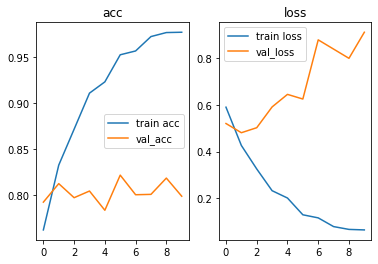

79/79 [==============================] - 26s 332ms/step - loss: 0.4772 - sparse_categorical_accuracy: 0.8152


[0.47718197107315063, 0.8151999711990356]

In [ ]:
from tensorflow import keras
import tensorflow_hub as hub
import os
import tensorflow_text as text
import tensorflow as tf
import typing
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import typing
from keras.utils.vis_utils import plot_model
if typing.TYPE_CHECKING:
    from keras.api._v2 import keras
# os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"
# if os.environ['COLAB_TPU_ADDR']:
#   cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#   tf.config.experimental_connect_to_cluster(cluster_resolver)
#   tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#   strategy = tf.distribute.TPUStrategy(cluster_resolver)
#   print('Using TPU')
# elif tf.config.list_physical_devices('GPU'):
#   strategy = tf.distribute.MirroredStrategy()
#   print('Using GPU')
# else:
#   raise ValueError('Running on CPU is not recommended.')

# 读取数据
train_data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_train.csv")
train_data=train_data.sample(frac=1)
x_train = np.array(train_data['text'])
x2_train = np.array(train_data['content'])
y_train = np.array(train_data['label'])
data = pd.read_csv("/content/drive/MyDrive/ESA/cleaned_data/cleaned_dev.csv")
data=data.sample(frac=1)
x_data = np.array(data["text"])
y_data = np.array(data["label"])
x2_data = np.array(data['content'])
x_dev = x_data[:2500]
x2_dev = x2_data[:2500]
y_dev = y_data[:2500]
x_test = x_data[-2500:]
x2_test = x2_data[-2500:]
y_test = y_data[-2500:]
y_train = y_train.astype(np.int32)
y_dev = y_dev.astype(np.int32)
y_test = y_test.astype(np.int32)
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.load("https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3")


def make_bert_preprocess_model(sentence_features, seq_length=50):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]
    bert_preprocess = preprocessor
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]
    truncated_segments = segments
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_input'],seq_length=32)
bert_preprocess_model2 = make_bert_preprocess_model(['text_input'],seq_length=128)


def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    text_input2 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text2')

    # preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
    encoder_inputs = bert_preprocess_model(text_input)
    encoder = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=True,
                             name='BERT_encoder')
    # 输入batch*seq 输出batch*seq*768
    outputs = encoder(encoder_inputs)
    # 输入batch*seq*768,输出batch*seq*512
    net = outputs['sequence_output']
    net = keras.layers.Conv1D(1024, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net)
    net = keras.layers.Attention()([net, net])
    # 输入batch*seq*768,输出batch*seq*512
    net3 = outputs['sequence_output']
    net3 = keras.layers.GRU(512, activation="tanh", recurrent_activation="sigmoid",return_sequences=True)(net3)
    net3 = keras.layers.Attention()([net3, net3])

    # 输入batch*seq*768,输出batch*seq*512
    encoder_inputs2 = bert_preprocess_model2(text_input2)
    encoder2 = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4", trainable=True, name='BERT_encoder2')
    outputs2 = encoder2(encoder_inputs2)
    net2 = outputs2['sequence_output']
    net2 = keras.layers.Bidirectional(
        keras.layers.GRU(256, activation="tanh", recurrent_activation="sigmoid",return_sequences=True))(net2)
    net2 = keras.layers.Attention()([net2, net2])
    # 输入3*batch*seq*512,输出batch*seq*1536
    net4 = keras.layers.Concatenate(axis=-2)([net, net2, net3])
    # 输入2*batch*seq*512,输出batch*seq*1024
    net5 = keras.layers.Concatenate(axis=-2)([net, net2])
    net6 = keras.layers.Concatenate(axis=-2)([net2, net3])
    net7 = keras.layers.Concatenate(axis=-2)([net, net3])
    # 输入batch*seq*1536输出batch*seq/2*64
    r1 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net)
    r1 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r1)
    r1 = keras.layers.MaxPooling1D(2)(r1)
    r1 = keras.layers.Flatten()(r1)
    r1 = tf.keras.layers.Dropout(0.2)(r1)
    r1 = keras.layers.Dense(128, activation='relu')(r1)

    r2 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net2)
    r2 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r2)
    r2 = keras.layers.MaxPooling1D(2)(r2)
    r2 = keras.layers.Flatten()(r2)
    r2 = tf.keras.layers.Dropout(0.2)(r2)
    r2 = keras.layers.Dense(128, activation='relu')(r2)

    r3 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(net3)
    r3 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r3)
    r3 = keras.layers.MaxPooling1D(2)(r3)
    r3 = keras.layers.Flatten()(r3)
    r3 = tf.keras.layers.Dropout(0.2)(r3)
    r3 = keras.layers.Dense(128, activation='relu')(r3)

    r4 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net4)
    r4 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r4)
    r4 = keras.layers.MaxPooling1D(2)(r4)
    r4 = keras.layers.Flatten()(r4)
    r4 = tf.keras.layers.Dropout(0.2)(r4)
    r4 = keras.layers.Dense(128, activation='relu')(r4)

    r5 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net5)
    r5 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r5)
    r5 = keras.layers.MaxPooling1D(2)(r5)
    r5 = keras.layers.Flatten()(r5)
    r5 = tf.keras.layers.Dropout(0.2)(r5)
    r5 = keras.layers.Dense(128, activation='relu')(r5)

    r6 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net6)
    r6 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r6)
    r6 = keras.layers.MaxPooling1D(2)(r6)
    r6 = keras.layers.Flatten()(r6)
    r6 = tf.keras.layers.Dropout(0.2)(r6)
    r6 = keras.layers.Dense(128, activation='relu')(r6)

    r7 = keras.layers.Conv1D(512, 3, activation="relu", padding="same", strides=1)(net7)
    r7 = keras.layers.Conv1D(128, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.Conv1D(64, 3, activation="relu", padding="same", strides=1)(r7)
    r7 = keras.layers.MaxPooling1D(2)(r7)
    r7 = keras.layers.Flatten()(r7)
    r7 = tf.keras.layers.Dropout(0.2)(r7)
    r7 = keras.layers.Dense(128, activation='relu')(r7)

    # r8 = outputs2['pooled_output']
    # r8 = keras.layers.Dropout(0.2)(r8)
    # r8 = keras.layers.Dense(64, activation='relu')(r8)

    # r9 = outputs['pooled_output']
    # r9 = keras.layers.Dropout(0.2)(r9)
    # r9 = keras.layers.Dense(64, activation='relu')(r9)

    res = keras.layers.Concatenate(axis=-1)([r1, r2, r3, r4, r5, r6, r7])
    res = keras.layers.Dropout(0.2)(res)
    res = keras.layers.Dense(3, activation='softmax')(res)
    return keras.Model([text_input, text_input2], res)


model = build_classifier_model()
model_png="/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru_CNN2"
tem_path=os.path.exists(model_png)
if not tem_path:
  os.makedirs(model_png)
plot_model(model,to_file=model_png+"/model.png",show_shapes=True)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-05),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["sparse_categorical_accuracy"])
checkpoint_path = "/content/drive/MyDrive/ESA/checkpoint/gru_cnn_bigru_CNN2/model.ckpt"
if os.path.exists(checkpoint_path + ".index"):
    model.load_weights(checkpoint_path)
model_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)
early_stop=keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy",patience=4)
model_history = model.fit([x_train,x2_train], y=y_train, epochs=20, batch_size=32,
                          validation_data=([x_dev,x2_dev], y_dev),
                          validation_freq=1,
                          callbacks=[model_callback,early_stop],shuffle=True)
#model.save_weights(checkpoint_path)
model.summary()
# 画出acc和loss曲线
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.subplot(1, 2, 1)
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val_acc")
plt.title("acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.title("loss")
plt.legend()
plt.show()
model.load_weights(checkpoint_path)
model.evaluate(x=[x_test,x2_test],y=y_test)